# Project 4 - Companies Fundamentals Analysis

Bowen Chen

Feburary 9, 2018

## Executive Summary

In this project, the companies fundamental data is studied the evaluated. The annual frequency of fundamental data of all companies from 1950 to 2017 was downloaded from WRDS's CapitalIQ database. There are a large amount of data unavailiable - some of the data has been transformed to 0, while others are left untouched. There are two analysis being completed on this dataset,

**1. The top industries based on the aggregated metrics**

Some summary statistics of this study

| Category | Industry Name | Value  |
|--------------|------------|-------------|
| Largest Cash Flow | Banking (Money Center) | \$ 1636.46  |
| Largest Market Size | Banking (Money Center) | \$ 12404.47  |
| Highest Leverage | Agriculture | 96.39 (D/E) |
| Highest Return on Assets | Food | 0.071(ROA) |

**2. The different behaviors of companies with different status**

Some summary statistics of this study

| Company Status | Market Size | Net Income |
|----------------|-------------|------------|
| Active              | \$ 1864.5966   | \$ 154.51666  |
| Incative              | \$ 183.6756    | \$ 15.54749   |


## Key Questions to Answer

* What are the top industries that has the largest cash flow, largest market size, highest leverage and highest return on assets?


* Is there a different behavior of companies that are active/inactive?

## Computation

In [34]:
# R Setup
options(repr.plot.width= 6, repr.plot.height=4, warn = -1)

library(data.table)
library(lubridate)
library(dplyr)
library(magrittr)
library(ggplot2)

**Import Data**

The data consists of daily returns for all stocks from 1926-1-1 to 2016-12-31, since the size of the file is huge, the use of data.table packages are very important here. The data contains the following fields,


* *GVKey* - The unique company identifier
* *date* - The date, in daily frequency
* *fyear* - Fiscal year
* *tic* - The corresponding ticker that the stock used in Exchange
* *conm* - Company name
* *fincf* - Cash flow for financing activity
* *ivncf* - Cash flow for investing activity
* *oancf* - Cash flow for opreating activity
* *rveqt* - Total Book Value of Equity
* *mkvalt* - Total Market Value of Equity
* *costat* - Company status, Inactive/Active
* *spcindcd* - S&P industry code

In [35]:
fundamentals  = fread('data/fundamentals.csv')

check the first couple of rows of the fundamentals data

In [98]:
fundamentals[1:5,]

| gvkey | datadate | fyear | tic  | conm                  | at    | dt | fincf | ivncf | ni     | oancf | rveqt | costat | mkvalt | spcindcd |
|-------|----------|-------|------|-----------------------|-------|----|-------|-------|--------|-------|-------|--------|--------|----------|
| 1000  | 19611231 | 1961  | AE.2 | A & E PLASTIK PAK INC | NA    | NA | NA    | NA    | NA     | NA    | NA    | I      | NA     | 325      |
| 1000  | 19621231 | 1962  | AE.2 | A & E PLASTIK PAK INC | NA    | NA | NA    | NA    | NA     | NA    | NA    | I      | NA     | 325      |
| 1000  | 19631231 | 1963  | AE.2 | A & E PLASTIK PAK INC | NA    | NA | NA    | NA    | 0.003  | NA    | NA    | I      | NA     | 325      |
| 1000  | 19641231 | 1964  | AE.2 | A & E PLASTIK PAK INC | 1.416 | NA | NA    | NA    | 0.052  | NA    | NA    | I      | NA     | 325      |
| 1000  | 19651231 | 1965  | AE.2 | A & E PLASTIK PAK INC | 2.310 | NA | NA    | NA    | -0.197 | NA    | NA    | I      | NA     | 325      |

There are large number of data unavaliable, which is expected for a company that is inactive

**Rename the columns**

Try to make the dataset look better

In [37]:
fundamentals = fundamentals %>% setNames(c("GVKey", "date", "Fiscal Year", "Ticker", 
                                              "Company Name","Total Assets", "Total Debt", "Fin_CashFlow", 
                                              "Inv_CashFlow", "Net Income", "Op_CashFlow", "Total Equity",
                                              "Company Status", "Mkt_Value_Equity", "SP_Industry"))

**Covert date**

The date column is character format which need to converted into date

In [38]:
fundamentals[,  `:=` (date = as.Date(as.character(date), 
                                   format = '%Y/%m/%d', 
                                   origin = "1910-10-01"))]

Combine companies that have multiple rows on the same year. 

In [39]:
fundamentals = fundamentals %>% group_by( GVKey,
                         `Fiscal Year`) %>%
                 summarise( Ticker = last(Ticker),
                            `Company Name` = last(`Company Name`),
                            `Total Assets` = sum(`Total Assets`, na.rm = T), 
                            `Total Debt` = sum(`Total Debt`, na.rm = T), 
                            `Fin_CashFlow` = sum(`Fin_CashFlow`, na.rm = T),
                            `Inv_CashFlow` = sum(`Inv_CashFlow`, na.rm = T),
                            `Op_CashFlow` = sum(`Op_CashFlow`, na.rm =T),   
                            `Net Income` = sum(`Net Income`, na.rm = T),
                            `Total Equity` = sum(`Total Equity`, na.rm =T),
                            `Company Status` = last(`Company Status`),
                             Mkt_Value_Equity = sum(Mkt_Value_Equity, na.rm = T),
                             SP_Industry = last(SP_Industry)                           
                          )%>% as.data.table()

** Find the leverage ratios **

Find ROA, ROE and D/E ratio. Since there are 0s present, we have to make conditions when finding these ratios

In [40]:
fundamentals[, DE :=  ifelse(`Total Equity`== 0, NA, `Total Debt`/`Total Equity`)]
fundamentals[, ROE :=  ifelse(`Total Equity`== 0, NA, `Net Income`/`Total Equity`)]
fundamentals[, ROA :=  ifelse(`Total Assets`== 0, NA, `Net Income`/`Total Assets`)]

**Summary of the Dataset**

Build a summary table on industry, we could find the average of these several metrics of different industry over the years

In [41]:
fundamentals_industry = fundamentals %>% group_by( SP_Industry) %>%
                 summarise( `Total Cash` =  mean(`Fin_CashFlow`+`Inv_CashFlow` + `Op_CashFlow`),
                             `Market Size` = mean(Mkt_Value_Equity, na.rm = T),
                            DE = mean(DE, na.rm =  T),
                            ROE = mean(ROE, na.rm = T),
                            ROA = mean(ROA, na.rm = T)
                          )%>% as.data.table()
fundamentals_industry = fundamentals_industry[complete.cases(fundamentals_industry), ]
fundamentals_industry[, SP_Industry := as.character(SP_Industry)]

Since there are a large number of industries that does not have total equity data avaliable, many companies' D/E or ROA could not be calculated, here we will show a summary table that has all sets of data are avaliable. With the summary table, we could find out several really interesting facts

**The industry that has the most cash flows**

In [99]:
fundamentals_industry[order(-`Total Cash`), ][1:5,]

| SP_Industry | Total Cash | 
|-------------|------------|
| 810         | 1636.45981 |
| 823         | 147.34548  |
| 822         | 135.20109  |
| 845         | 111.28382  |
| 830         | 62.46002   |

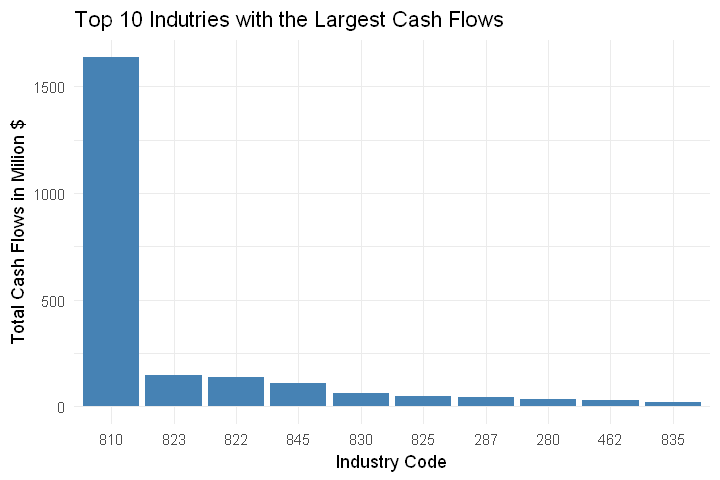

In [61]:
ggplot(data = fundamentals_industry[order(-`Total Cash`), ][1:10,], 
       aes(x = reorder(SP_Industry, -`Total Cash`), y = `Total Cash`)) +
  geom_bar(stat="identity", fill="steelblue")+
  labs(title = "Top 10 Indutries with the Largest Cash Flows",
  x = "Industry Code", 
  y = "Total Cash Flows in Milion $",
  parse = TRUE)+
  theme_minimal()

Industry 810 has the most average cash flow over the years, yep, it is the money center of the banking industry - **Banks (Money Center)**

** The industry that is largest in size **

In [100]:
fundamentals_industry[order(-`Market Size`), ][1:5,]

| SP_Industry |   Market Size |
|-------------|-------------|
| 810         | 12404.478   |
| 830         | 11283.062   |
| 280         | 4659.968    |
| 287         | 3095.290    |
| 823         | 2780.319    |

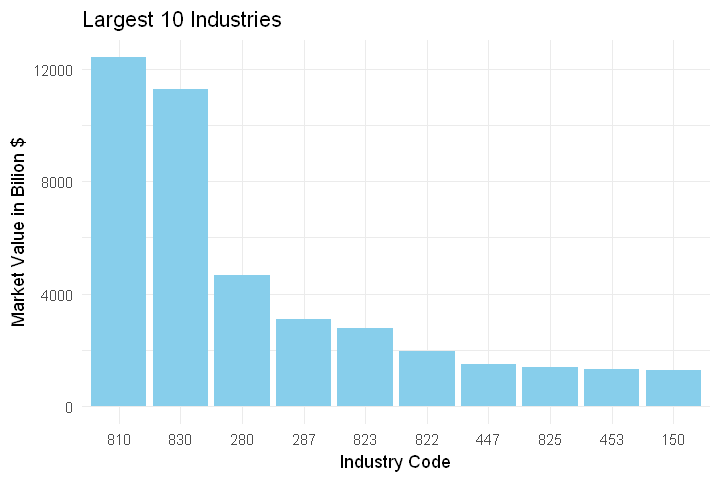

In [60]:
ggplot(data = fundamentals_industry[order(-`Market Size`), ][1:10,], 
       aes(x = reorder(SP_Industry, -`Market Size`), y = `Market Size`)) +
  geom_bar(stat="identity", fill="skyblue")+
  labs(title = "Largest 10 Industries",
  x = "Industry Code", 
  y = "Market Value in Bilion $",
  parse = TRUE)+
  theme_minimal()

Except for the **money center** that is the largest in size, industry 830 (**Insurance (Multi-Line)**) and industry 280 (health care) occupy large amount of total market values

**The industry that is most leveraged**

In [101]:
fundamentals_industry[order(-`DE`), ][1:5,]

| SP_Industry |  DE        | 
|-------------|-----------|
| 112         |  96.392010 | 
| 305         | 78.894727 | 
| 462         | 9.318660  | 
| 840         | 3.966211  | 
| 845         | 3.211773  | 

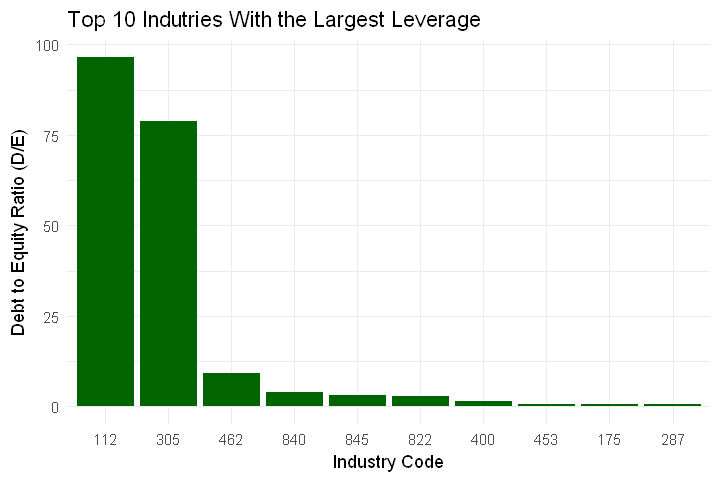

In [59]:
ggplot(data = fundamentals_industry[order(-DE), ][1:10,], 
       aes(x = reorder(SP_Industry, -DE), y = DE)) +
  geom_bar(stat="identity", fill="darkgreen")+
  labs(title = "Top 10 Indutries With the Largest Leverage",
  x = "Industry Code", 
  y = "Debt to Equity Ratio (D/E)",
  parse = TRUE)+
  theme_minimal()

Industry 112 (**Agriculture**) and industry 305 (**homebuilding**) has the most leverages. One could guess that these leverages are possibly due to the large project financing required in these industries. The rest of the indutries has relatively normal leverages ratios

**The industry that has the largest return on assets**

In [102]:
fundamentals_industry[order(-ROA), ][1:5,]

| SP_Industry | ROA         |
|-------------|-------------|
| 250         | 0.071491857 |
| 355         | 0.021308236 |
| 830         | 0.015193417 |
| 825         | 0.007969484 |
| 810         | 0.003403771 |

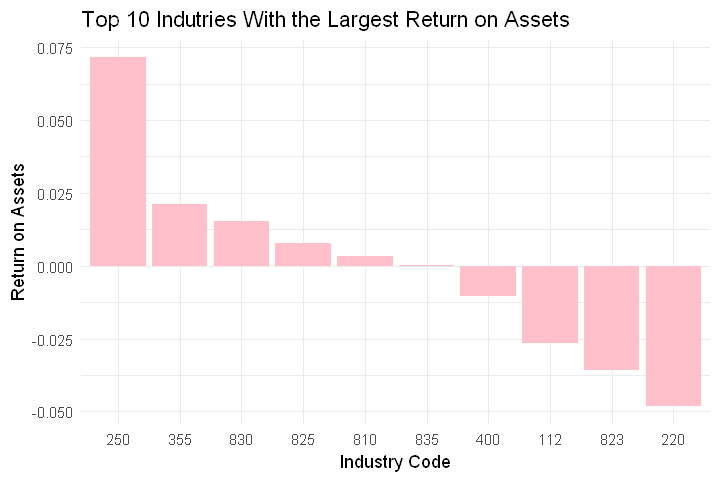

In [67]:
ggplot(data = fundamentals_industry[order(-ROA), ][1:10,], 
       aes(x = reorder(SP_Industry, -ROA), y = ROA)) +
  geom_bar(stat="identity", fill="pink")+
  labs(title = "Top 10 Indutries With the Largest Return on Assets",
  x = "Industry Code", 
  y = "Return on Assets",
  parse = TRUE)+
  theme_minimal()

While a large amount of data is not avaliable, many industries has recorded a loss on total assets. Most of the indutries that recorded loss has a large amount of inactive companies - therefore are the indutries that has been faded from the modern socitey

**Active and Inactive Companies**

Could there be a different behavior if the company is inactive? The table below already showed something really interesting

In [103]:
company_status = fundamentals %>% group_by(`Company Status`) %>%
                 summarise(`Market Size` = mean(Mkt_Value_Equity, na.rm = T),
                           `Net Income` =  mean(`Net Income`, na.rm = T)) %>% as.data.table()

| Company Status | Market Size | Net Income |
|----------------|-------------|------------|
| Active              | \$ 1864.5966   | \$ 154.51666  |
| Incative              | \$ 183.6756    | \$ 15.54749   |


In [93]:
company_status = melt(company_status,id.vars="Company Status")

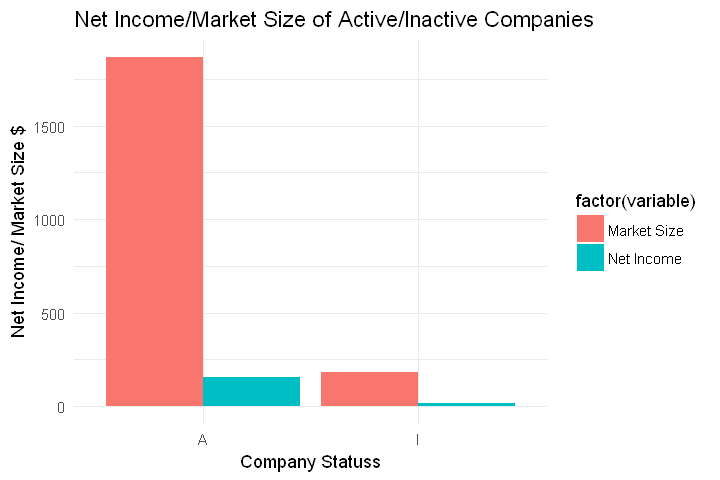

In [97]:
ggplot(data = company_status, 
       aes(x = `Company Status`,  y= value, fill= factor(variable))) +
  geom_bar(stat="identity", position="dodge")+
  labs(title = "Net Income/Market Size of Active/Inactive Companies",
  x = "Company Statuss", 
  y = "Net Income/ Market Size $",
  parse = TRUE)+
  theme_minimal()

Active companies are generally larger in size and have more net income